## Unit 3 lesson 4 - SVM on recipes
The challenge is to transform the data outcome to binary (good/bad recipe) clean the data and use support vector classifier to get decent results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
%matplotlib inline

In [2]:
# get the data
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# check for NaN values
null_count = raw_data.isnull().sum()
null_count[null_count > 0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

The challenge says that I need to get the dataset down to about 30 features. For this reason, I'll drop the columns with NaN value. I'll save the title for now so later it can be referred

In [4]:
raw_data = raw_data.drop(['calories', 'protein', 'fat', 'sodium'], 1)
raw_data.head()

,title,rating,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# dataframe info
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 676 entries, title to turkey
dtypes: float64(675), object(1)
memory usage: 103.4+ MB


In [6]:
# the values of the target column
print("the rating values are\n", raw_data['rating'].unique())

the rating values are
 [2.5   4.375 3.75  5.    3.125 1.875 0.    1.25 ]


I'll make the outcome (rating) a binary. The rating column has values from 0 to 5; for me, I decided that anything above and including 4 will be considered as good(1), all the rest as bad (0).<br> A problem might be that there will be many in one category vs. the other. Yet, I'll continue and see what we get.

In [7]:
good_val = (raw_data['rating'] >= 4.0).sum()
total_val = len(raw_data)
print("There are a total of {} good values out of {} values in the dataset".format(good_val, total_val))

There are a total of 10738 good values out of 20052 values in the dataset


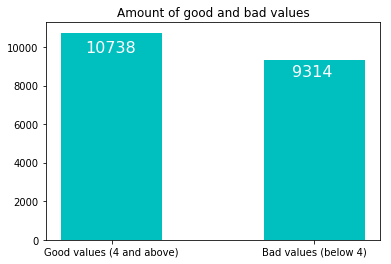

In [8]:
# bar plot the amount of each data
plt.bar([1,2], [good_val, total_val - good_val], width=0.5, color='c')

# add the x labels
plt.xticks([1,2], ('Good values (4 and above)', 'Bad values (below 4)'))

# add the amount of each bar
plt.text(0.87, good_val - 1000, good_val, fontsize=16, color='white')
plt.text(1.89, 8500, total_val - good_val, fontsize=16, color='white')

plt.title('Amount of good and bad values')
plt.show()

In [9]:
# make the rating binary
good_rcp = raw_data['rating'] >= 4
raw_data['rating'] = np.where(good_rcp, 1, 0)
raw_data.head()

,title,rating,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature selection
first I'll check all the existing columns, and organize them alphabetically according to their first letter. That way if one is more interested in specific food it will be easier to find and keep these columns

In [10]:
# get all the printable chars
char_list = []
for char in string.printable:
    char_list.append(char)

In [11]:
# print all the features by their starting letter with space in between
for i in range(len(char_list)):
    by_char_list = list(filter(lambda x: x.lower().startswith(char_list[i]), raw_data.columns))
    if by_char_list == []:
        continue
    else:
        print(by_char_list)
        print("\n")

['22-minute meals']


['3-ingredient recipes', '30 days of groceries']


['advance prep required', 'alabama', 'alaska', 'alcoholic', 'almond', 'amaretto', 'anchovy', 'anise', 'anniversary', 'anthony bourdain', 'aperitif', 'appetizer', 'apple', 'apple juice', 'apricot', 'arizona', 'artichoke', 'arugula', 'asian pear', 'asparagus', 'aspen', 'atlanta', 'australia', 'avocado']


['back to school', 'backyard bbq', 'bacon', 'bake', 'banana', 'barley', 'basil', 'bass', 'bastille day', 'bean', 'beef', 'beef rib', 'beef shank', 'beef tenderloin', 'beer', 'beet', 'bell pepper', 'berry', 'beverly hills', 'birthday', 'biscuit', 'bitters', 'blackberry', 'blender', 'blue cheese', 'blueberry', 'boil', 'bok choy', 'bon appétit', 'bon app��tit', 'boston', 'bourbon', 'braise', 'bran', 'brandy', 'bread', 'breadcrumbs', 'breakfast', 'brie', 'brine', 'brisket', 'broccoli', 'broccoli rabe', 'broil', 'brooklyn', 'brown rice', 'brownie', 'brunch', 'brussel sprout', 'buffalo', 'buffet', 'bulgaria', 'bulgur', '

In [12]:
# choosing 30 random features 
cols = ['chicken', 'christmas', 'israel', 'hamburger', 'high fiber','lemon',
        'hummus', 'grill', 'california', 'burrito', 'raspberry','low carb',
        'bake', 'alcoholic', 'cake', 'dinner', 'mozzarella', 'pizza',
        'rice', 'salmon', 'meat', 'denver', 'dessert', 'chocolate',
        'cucumber', 'tomato', 'snack', 'apple', 'tuna', 'avocado']

X = raw_data[cols]
y = raw_data['rating']

X.head()

,chicken,christmas,israel,hamburger,high fiber,lemon,hummus,grill,california,burrito,...,meat,denver,dessert,chocolate,cucumber,tomato,snack,apple,tuna,avocado
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Data columns (total 30 columns):
chicken       20052 non-null float64
christmas     20052 non-null float64
israel        20052 non-null float64
hamburger     20052 non-null float64
high fiber    20052 non-null float64
lemon         20052 non-null float64
hummus        20052 non-null float64
grill         20052 non-null float64
california    20052 non-null float64
burrito       20052 non-null float64
raspberry     20052 non-null float64
low carb      20052 non-null float64
bake          20052 non-null float64
alcoholic     20052 non-null float64
cake          20052 non-null float64
dinner        20052 non-null float64
mozzarella    20052 non-null float64
pizza         20052 non-null float64
rice          20052 non-null float64
salmon        20052 non-null float64
meat          20052 non-null float64
denver        20052 non-null float64
dessert       20052 non-null float64
chocolate     20052 non-null float64
cuc

## Run SVC
with the reduced data (X) and the binary target (y)

In [14]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
# train the model
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [16]:
# get score
svm.score(X_test, y_test)

0.5533577127659575

The results are not good, but are a bit better than in the model (unit three lesson 4.4) where the score was about -0.01.

We can try to find the "best" features and train the model again, see if we improve the results from the random selected ones

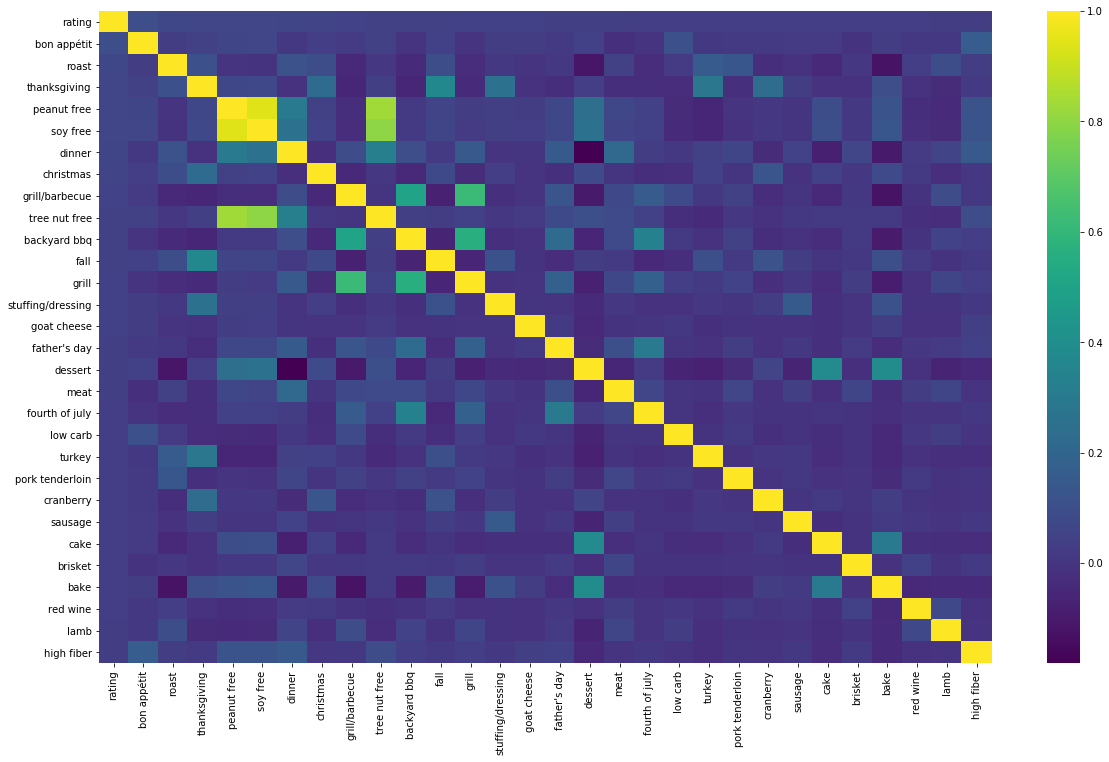

In [17]:
# Running this take some time

# defining variables
numerical_feature_columns = list(raw_data._get_numeric_data().columns)
target = 'rating'
k = 30

# use correlation and heat map
cols = raw_data[numerical_feature_columns].corr().nlargest(k, target)[target].index
cm = raw_data[cols].corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm, cmap = 'viridis')

Based on the color of the heat map, none of the features has any strong correlation with the target variable, rating. Still, let's confirm

In [18]:
X2 = raw_data[cols]

X2_train, X2_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [19]:
svm = SVC(kernel = 'linear')
svm.fit(X2_train, y_train)

svm.score(X2_test, y_test)

0.5495345744680851

## Summary 
The model didn't do great in both forms I tried. It's basically like a coin flip. So unforthently, I cannot help the author of the cooking book with recommendation on what type of food to put on his book to make it more successful. 

Some of the problems with this data are its bais. Human ranking a dish is very subjective and can change between people. Also, when human rank a meal they tend to round the numbers (very good or very bad), it can be shown when I split the data, even though I defined only 4-5 to be considered as good (which is only 1/5 of the total possible outcomes) the good rated dishes were the majority of the data set. 